**NOTE:** This is a notebook supporting a blog post. More than likely I will not just convert the notebook into markdown and publish. Instead, I'll likely be selective with what code I show in the blogpost _and_ I'll likely upload manually annotated graphviz plots for the final post.

# New Bayesian and Causal inference workflows in PyMC: Introducing the `do` operator and `observe`

We've got some exciting experimental new functionality coming to PyMC which helps users do graph manipulation. If you don't know what that is, then you will soon! But know that this will be particularly useful in both Bayesian and Causal inference workflows.

This post is going to cover a lot of ground, so strap in. Readers of this post are going to learn:
* That PyMC models are represented behind the scenes as Bayesian DAGS (a type of graph)
* That we can manipulate these graphs in a variety of ways for fun and profit
* How new `do` operator and `observe` function can be used in the Bayesian and _causal_ inference workflows

**NOTE:** The functionality we talk about in this post, relies on some experimental code. Therefore these functions exist in the suitably named [`pymc-experimental`](https://github.com/pymc-devs/pymc-experimental) repo. This new functionality will migrate into the main PyMC repo and be available to all users in the near future.

Setup an environment as follows:

```bash
mamba create -n do_blog_post python=3.11 pymc-base matplotlib numpy pandas seaborn scipy jupyterlab ipykernel python-graphviz
mamba activate do_blog_post
python -m ipykernel install --user --name do_blog_post
pip install pymc-experimental
pip install daft
```

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import pymc_experimental as pmx
import seaborn as sns
from packaging import version

In [2]:
# check we have the required versions
assert version.parse(pm.__version__) >= version.parse('5.5.0')
assert version.parse(pt.__version__) >= version.parse('2.12.3')
assert version.parse(pmx.__version__) >= version.parse('0.0.7')

In [3]:
# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 1234
rng = np.random.default_rng(SEED)

Conducting Bayesian inference using MCMC methods in the current era has two key requirements: 

- log probability density for any given set of latent parameters and data, and 
-  gradient information about that log probability density.

However, an optional component of probabilistic programming libraries (PPL's) would be to have a representation of the graph structure of any given model. PyMC is one of those libraries! While having a graph representation of computations is common in various deep learning and related frameworks (e.g. [TensorFlow](https://www.tensorflow.org/guide/intro_to_graphs), [PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/), [JAX](https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html), [Pyro](https://github.com/pyro-ppl/pyro)/[NumPyro](https://num.pyro.ai/en/stable/), [Oryx](https://github.com/jax-ml/oryx), [aesara](https://aesara.readthedocs.io/en/latest/)/[aeMCMC](https://aemcmc.readthedocs.io/en/latest/index.html)/[aePPL](https://github.com/aesara-devs/aeppl)), it is not ubiquitous. For example, neither [JAGS](https://en.wikipedia.org/wiki/Just_another_Gibbs_sampler) nor [STAN](https://mc-stan.org) have an internal graph-based representation - they are centered around the log probability and its gradient. 

One advantage that PyMC has (over JAGS and STAN) is that the graph representation is a first-class citizen. So when you build your PyMC model, a symbolic graph representation of the model is constructed which is then relatively easy to manipulate in various ways. Interested readers should check out videos by [Ricardo Vieira](https://github.com/ricardoV94) ([Video A](https://www.youtube.com/watch?v=0B3xbrGHPx0), [Video B](https://www.youtube.com/watch?v=_APNiXTfYJw)). One promising use case for this is automagical graph transformations - here PyMC could analyse a model and simplify it, by looking for conjugate priors for example. Another use case is explicit user-driven modification of the graph which we'll focus on in this post. To understand what we mean in more detail, let's consider some routine functionality that has been in PyMC for some time now, that of out-of-sample posterior prediction.

If you're feeling a bit lost already, let's take a look at a simple example. A [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) is a mathematical construct which consists of nodes and edges (relationships between the nodes). To get a basic idea, we could take an equation such as $e = mc^2$ and represent that as a computation graph. 
When we build probabilistic programs to represent various quantities (known, unknown, stochastic, and deterministic) and their relationships, we are conceptually building a symbolic graph representation of our probabilistic programme. This can then be used to evaluate the log probability of particular parameter values given observed data (and the corresponding gradient information). But by building an explicit representation of the graph structure, we retain a symbolic representation of our probabilistic programme. We can then manipulate this in various ways - something that is not possible if we just build a black box which outputs log probability and gradient information. 

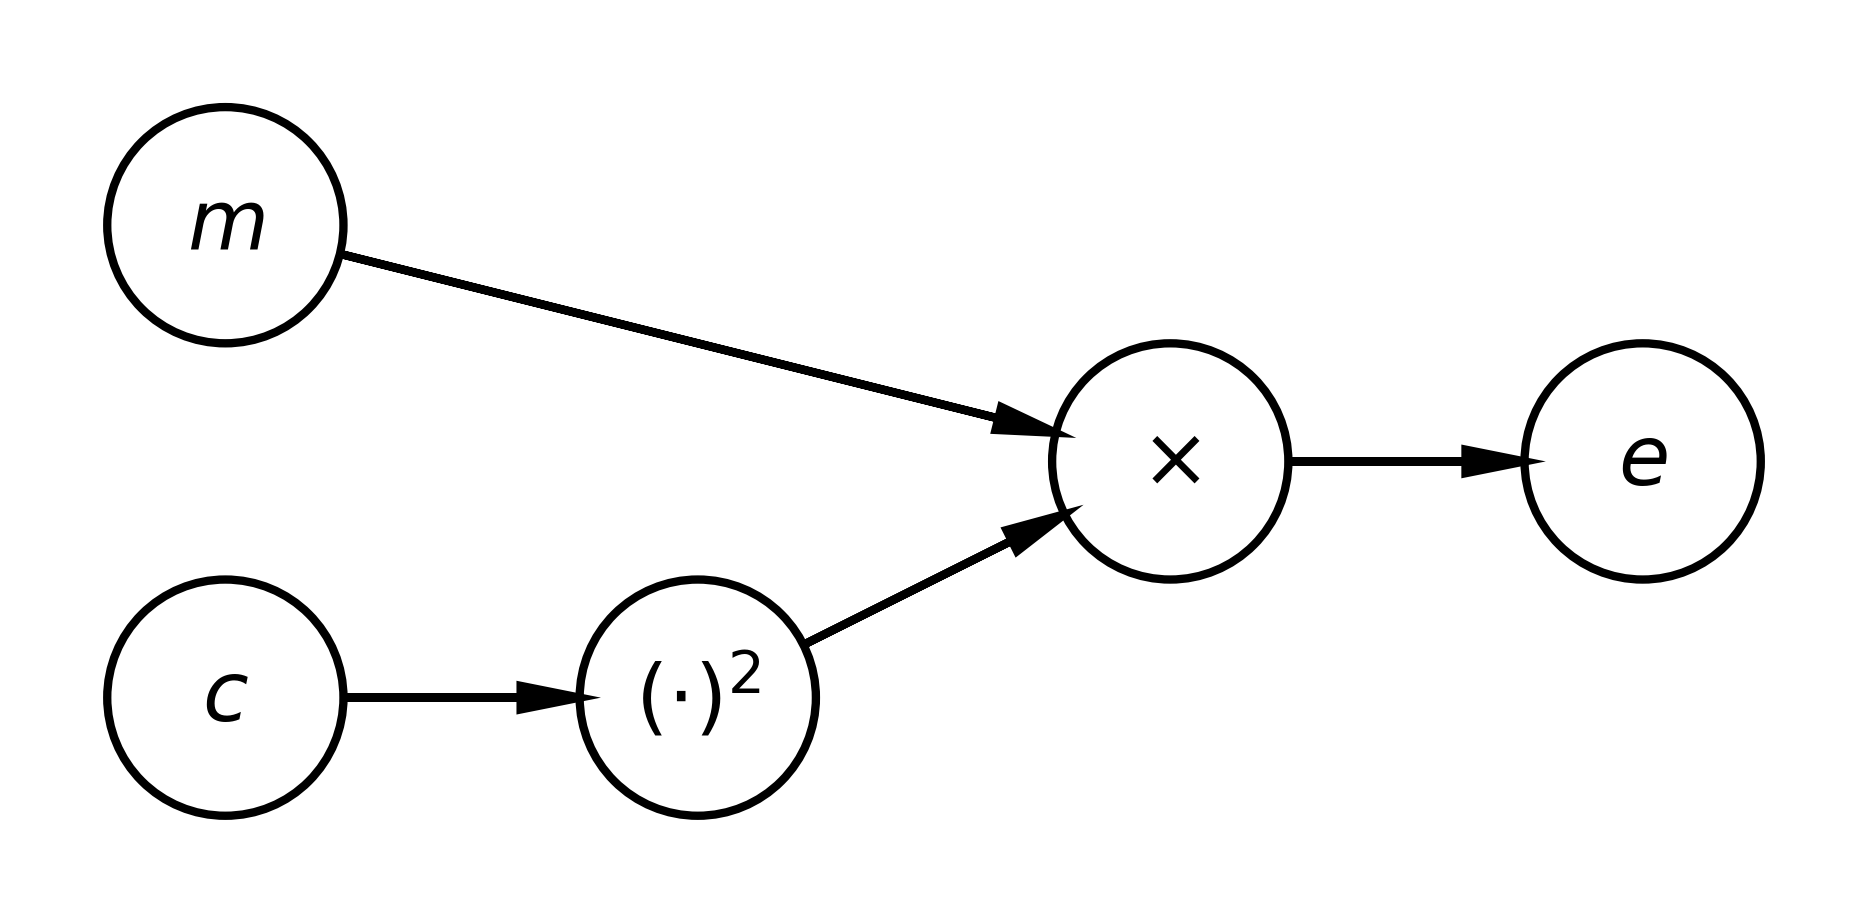

In [5]:
pgm = daft.PGM()
pgm.add_node("m", "$m$", -1, 1)
pgm.add_node("c", "$c$", -1, 0)
pgm.add_node("sq", "$(\cdot)^2$", 0, 0)
pgm.add_node("times", r"$\times$", 1, 0.5)
pgm.add_node("e", "$e$", 2, 0.5)
pgm.add_edge("c", "sq")
pgm.add_edge("sq", "times")
pgm.add_edge("m", "times")
pgm.add_edge("times", "e")
pgm.render(dpi=300);

## Example 1 - Using `do` in a Bayesian workflow for out-of-sample posterior prediction

Let's examine a simple univariate regression problem as an example. A typical (but not complete) Bayesian workflow would consist of the following stages:
* Load our data (though here we will simulate it).
* Build a PyMC model of the data generating process.
* Run inference on the unknown coefficients with `pm.sample`. This generates MCMC samples of posterior distribution.
* Run out-of-sample posterior prediction by updating the observed predictor values $X$ (`MutableData` nodes) with new values, $X'$ with `do`.

In [6]:
# Simulate some data
N = 20
x = rng.normal(0, 1, N)
y = -2 + 0.5 * x + -0.8 * x**2 + rng.normal(0, 0.2, N)
df = pd.DataFrame({"x": x, "y": y})

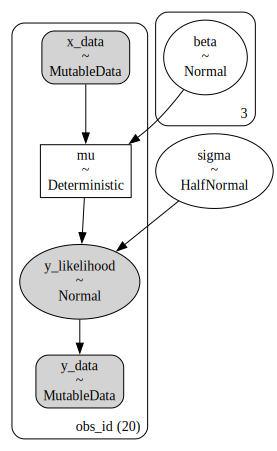

In [7]:
# Build a PyMC model
with pm.Model(coords_mutable={"obs_id": np.arange(N)}) as model:
    x_data = pm.MutableData('x_data', df['x'], dims="obs_id")
    y_data = pm.MutableData('y_data', df['y'], dims="obs_id")
    beta = pm.Normal('beta', shape=3)
    sigma = pm.HalfNormal('sigma')
    mu = pm.Deterministic("mu", beta[0] + beta[1] * x_data + beta[2] * x_data**2, dims="obs_id")
    pm.Normal('y_likelihood', mu=mu, sigma=sigma, observed=y_data, dims="obs_id")
    
pm.model_to_graphviz(model)

In [8]:
# conduct inference
with model:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Graph manipulation - the old way

Users of PyMC will already know that we can already accomplish out-of-sample posterior prediction by changing the values of the observed data used in the inference step. What may not have been obvious is that this is a form of graph manipulation. We are not just chaning the _values_ of the data but we are chaning the _shape_ of the graph when we inject vectors of data (for example) of different sizes.

The existing workflow uses `pm.set_data` to manipulate the `pm.MutableData` nodes in our model. There are plenty of example notebooks demonstrating the use of `pm.set_data` on the [PyMC Examples gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html) section of the website.

In [9]:
NI = 100
xi = np.linspace(-3, 3, NI)
yi = np.full(NI, np.nan)
     
with model:
    pm.set_data({'x_data': xi, 'y_data': yi}, coords={"obs_id": np.arange(NI)})
    idata.extend(pm.sample_posterior_predictive(idata, predictions=True, var_names=["mu"], random_seed=SEED))

Sampling: []


What we've done here is to manipulate the graph by injecting new data into the $x$ and $y$ `MutableData` nodes. If we visualise the model, we can see this as the label in the plate now shows that we have 100 instances of these variables in the graph.

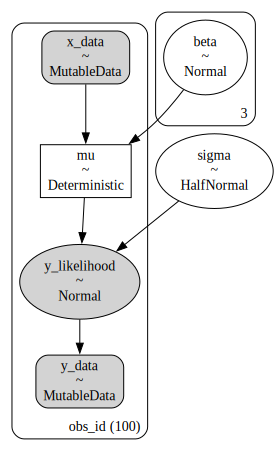

In [10]:
pm.model_to_graphviz(model)

### Graph manipulation - the new way with the `do` operator

So let's introduce the `do` operator. This function allows you to do graph manipulation in the same way that we achieved with `pm.set_data`. Though if you read on further you'll see that this is just the tip of the iceberg.

In [11]:
with do(model, {'x_data': xi}) as model_pred:
    idata_pred = pm.sample_posterior_predictive(idata, predictions=True, var_names=["mu"], random_seed=SEED)

Sampling: []


Notice that what we are doing here is quite different! The `do` function takes in a model and a dictionary of values we wish to change. What we get out is a _new model_. In this situation, we used that new model to sample from the posterior predictive distribution.

We can check what the graph looks like, and confirm to our satisfaction that we have the same graph produced through `pm.set_data` and the new approach of using `do`.

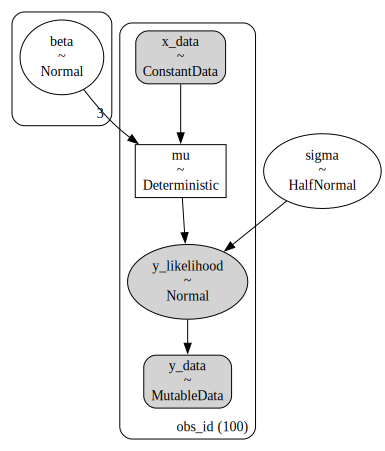

In [12]:
pm.model_to_graphviz(model_pred)

And to doubly confirm, we can plot the result of the out-of-sample posterior prediction next to each other and see that we get the same result.

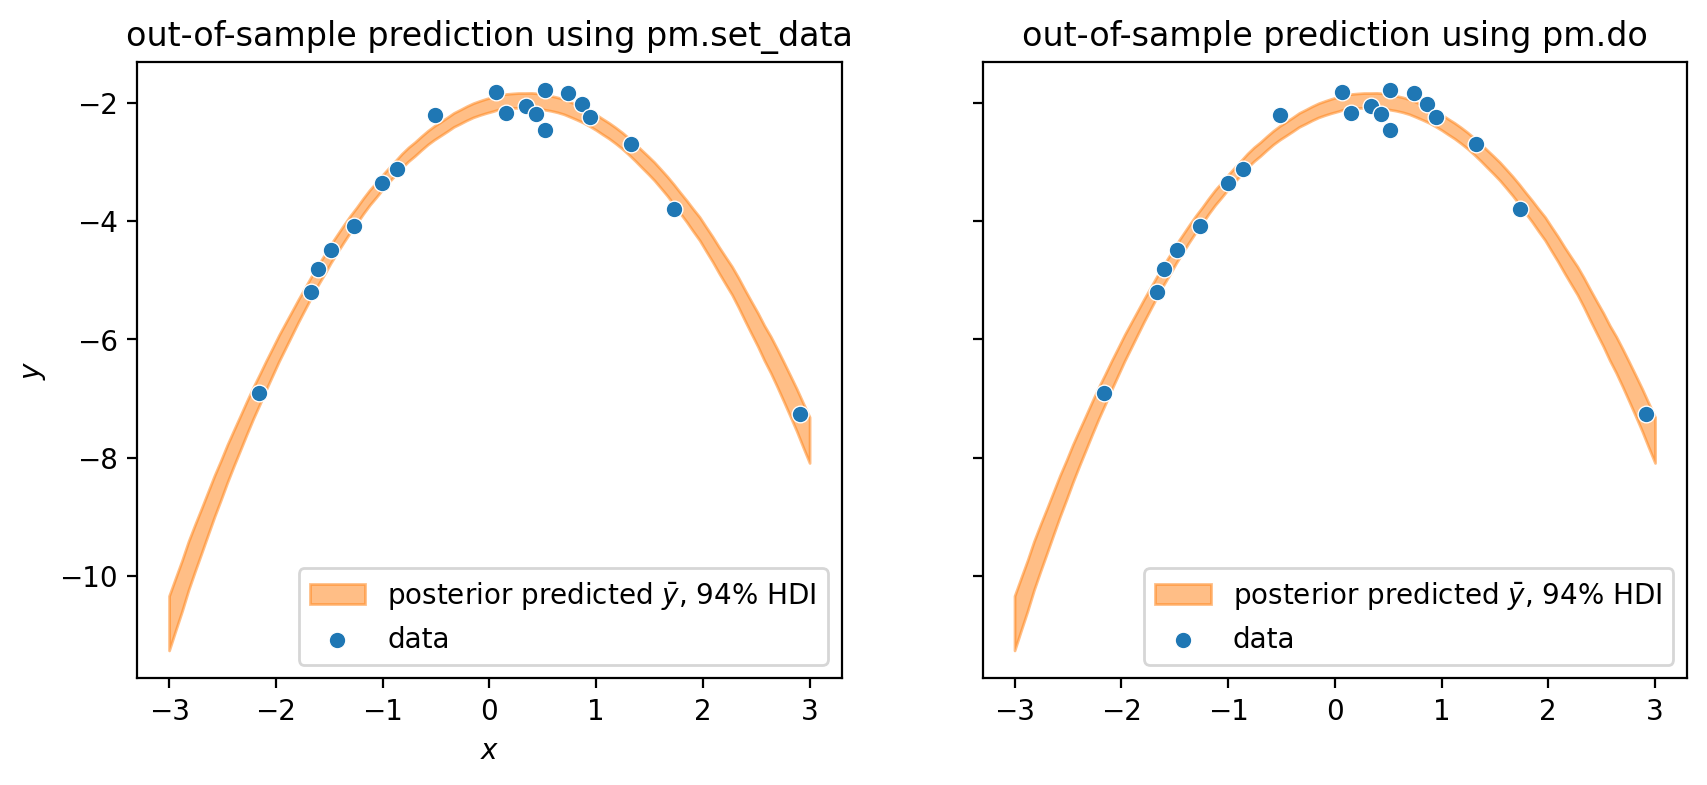

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

az.plot_hdi(xi, idata.predictions['mu'], 
            smooth=False, 
            ax=ax[0], 
            fill_kwargs={"label": r"posterior predicted $\bar{y}$, 94% HDI"})
sns.scatterplot(df, x=x, y=y, ax=ax[0], label='data')
ax[0].set(title="out-of-sample prediction using pm.set_data", xlabel=r"$x$", ylabel=r"$y$")
ax[0].legend()

az.plot_hdi(xi, idata_pred.predictions['mu'], 
            smooth=False, 
            ax=ax[1], 
            fill_kwargs={"label": r"posterior predicted $\bar{y}$, 94% HDI"})
sns.scatterplot(df, x=x, y=y, ax=ax[1], label='data')
ax[1].set(title="out-of-sample prediction using pm.do")
ax[1].legend();

In summary, this first example has introduced the concept of graph manipulation in an already commonly used situation -- out-of-sample posterior prediction.

So far we've only seen that we can use the `do` operator to inject new data into `MutableData` nodes. But let's take this to 11 and see what we can do ;)

## Example 2 - Taking your Bayesian causal inference workflow to the next level - graph manipulation with `observe` and `do`.

You might have read that you can't do causal inference in a Bayesian framework, and if you take a restricted or very formal definition of Bayesian statistics, maybe such an argument can be constructed. But as we're showing here, there really is nothing from stopping us from using the causal methods and adding them into our Bayesian toolbox. At the end of the day, these are all just tools and in this instance we can combine them to get the best of both worlds.

### The Bayesian Causal Network we'll work with

In this post, we'll be working with an idiomatic causal directed acyclic graph (DAG) where we have a binary treatment variable $Z$ which may or may not causally influence an outcome $Y$. However, this relationship suffers from confounding by $C$ which causally influences both treatment and outcome.

Further, we turn this into a Bayesian causal DAG by specifying probabilistic causal relationships between the nodes. A prior is placed on $C$ as it has no parent nodes.

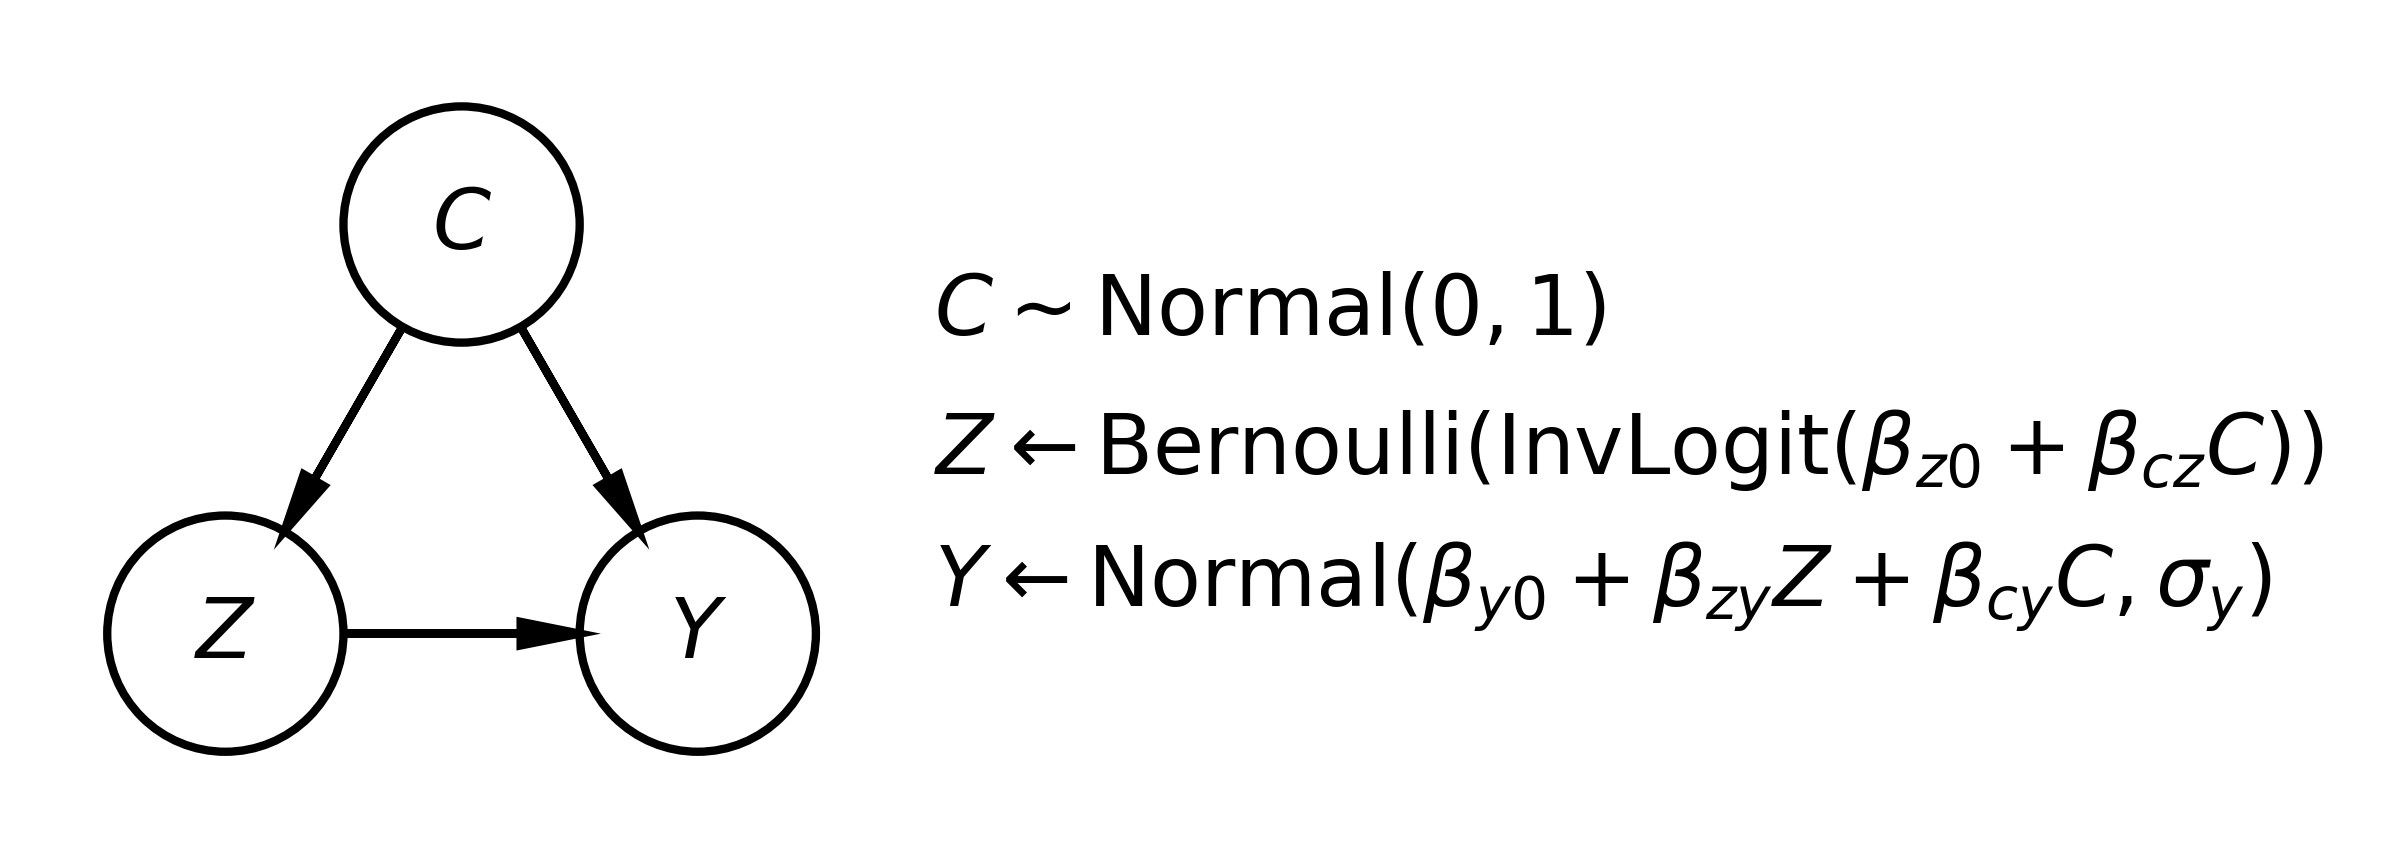

In [14]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(0.5, 0.3, r"$Z \leftarrow \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$")
pgm.add_text(0.5, 0, r"$Y \leftarrow \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$")
pgm.render(dpi=300);

Because our main relationship of interest here is between the treatment $Z$ and the outcome $Y$, then we can see that this example corresponds to the idiomatic _confounded relationship_.

Our goal in this example is to establish the strength of the $Z \rightarrow Y$ causal relationship. Because we constructed this example, we know that if $\beta_{ZY}=0$ then there is no causal association, but if we can determine (using Bayesian methods) that $\beta_{ZY} \neq 0$ then we could conclude that there is a causal relationship, $Z \rightarrow Y$.

Because the focus of this blog post is to introduce the `do` operator, we will not develop this example fully and omit the evaluation of a Bayes Factor to test the hypothesis that $\beta_{ZY}=0$.

Before we dive in to the example, let's just specify some notation to make life a bit simpler:
* We have random variables $C$, $Z$, and $Y$
* These are different from observations, specific values, $c$, $z$, and $y$
* We have a set of latent parameters, $\theta = \{ \beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{zy}, \beta_{cz}, \sigma_{y} \}$

### Define the full data generating process in a PyMC model

This next step may seem slightly alien to many existing PyMC users. We are going to define an 'empty' model, not conditioned on any data at all. This can be thought of as a 'pure' description of our data generating process, totally divorced from data.

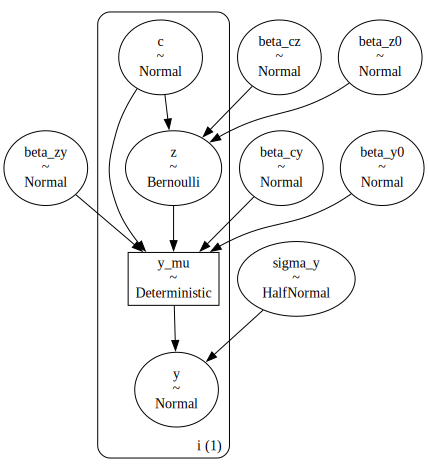

In [15]:
with pm.Model(coords_mutable={'i': [0]}) as model_generative:
    # priors on y <- c -> z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on z -> y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims='i')
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims='i')
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims='i')
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims='i')
        
    
pm.model_to_graphviz(model_generative)

### Simulate data by condition upon true parameter values and sampling

Having defined the full joint distribution, we are going to use it to generate simulated data. In order to do that, we are going to specify some true parameter values that govern the causal relationships between nodes.  So let's do that and use the `do` function to generate a new model - when we plot that we can see that the parameters are now observed nodes.

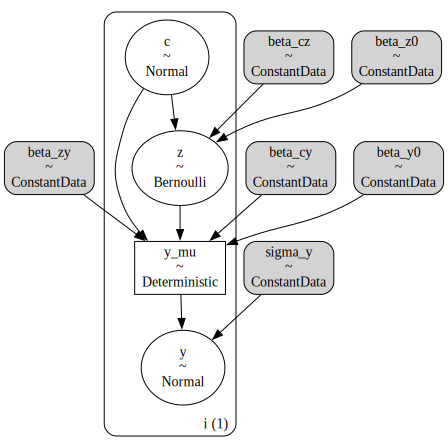

In [16]:
true_ATE = 1.0

true_values = {"beta_z0": 0.0, 
               "beta_y0": 0.0, 
               "beta_cz": 1.5, 
               "beta_zy": true_ATE, 
               "beta_cy": 1.0, 
               "sigma_y": 0.2}

model_simulate = do(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

It's important to pay attention to what we've just done. We took a model of the data generating process where there was no observed data, no conditioning. But we've returned a new and different model where we have now conditioned upon certain parameter values.

Next, we'll sample from this new model to obtain samples from distibution $P(C, Z, Y | \theta)$.

Sampling: [c, y, z]


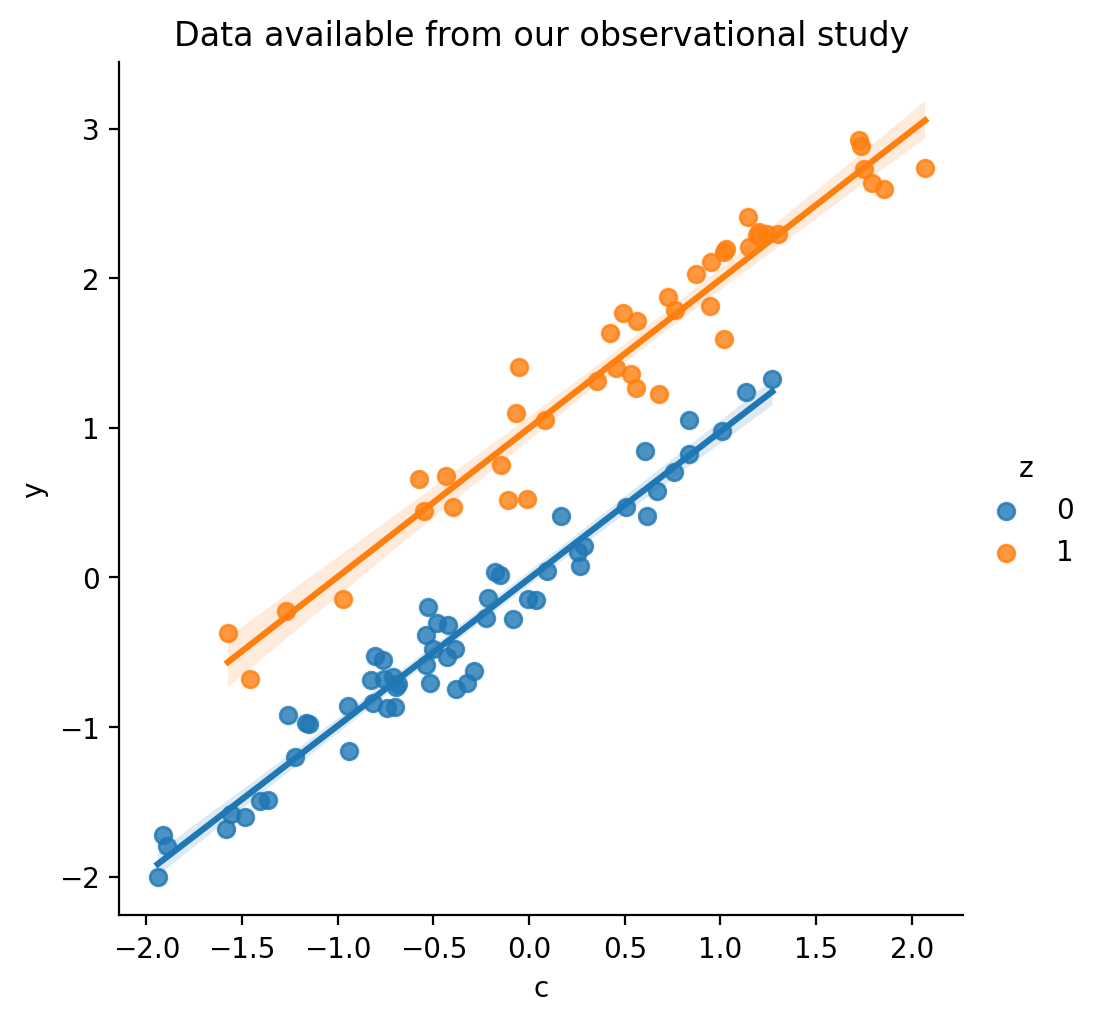

In [17]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)
    
observed = {"c": simulate.prior['c'].values.flatten(), 
            "y": simulate.prior['y'].values.flatten(),
            "z": simulate.prior['z'].values.flatten()}

df = pd.DataFrame(observed).sort_values("c", ascending=False)
ax = sns.lmplot(df[["c", "z", "y"]], x="c", y="y", hue="z")
ax.set(title="Data available from our observational study");

_Note that these fits + shaded error regions are not Bayesian fits. These are carried out automatically by `seaborn`'s `lmplot` function._

### Inference, $P( \theta | c, z, y)$

Now we'll go back to our original model (`model_generative`), and use the `observe` function to provide our observed data. This will again perform graph manipulation and give us a new model which will be suitable for infering posterior distributions over the unknown parameter values given the data we previously simulated.

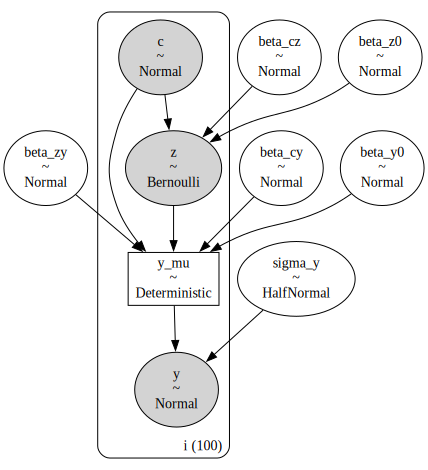

In [18]:
model_inference = observe(model_generative, {"c": df['c'], "y": df['y'], "z": df['z']})
model_inference.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference)

Now we can press the Inference Button and sample from our posterior.

In [19]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can inspect our posterior distributions easily using `arviz`. By plotting the known parameter values we used to generate the simulated data, we can confirm that the inference step has done a good job of estimating these values.

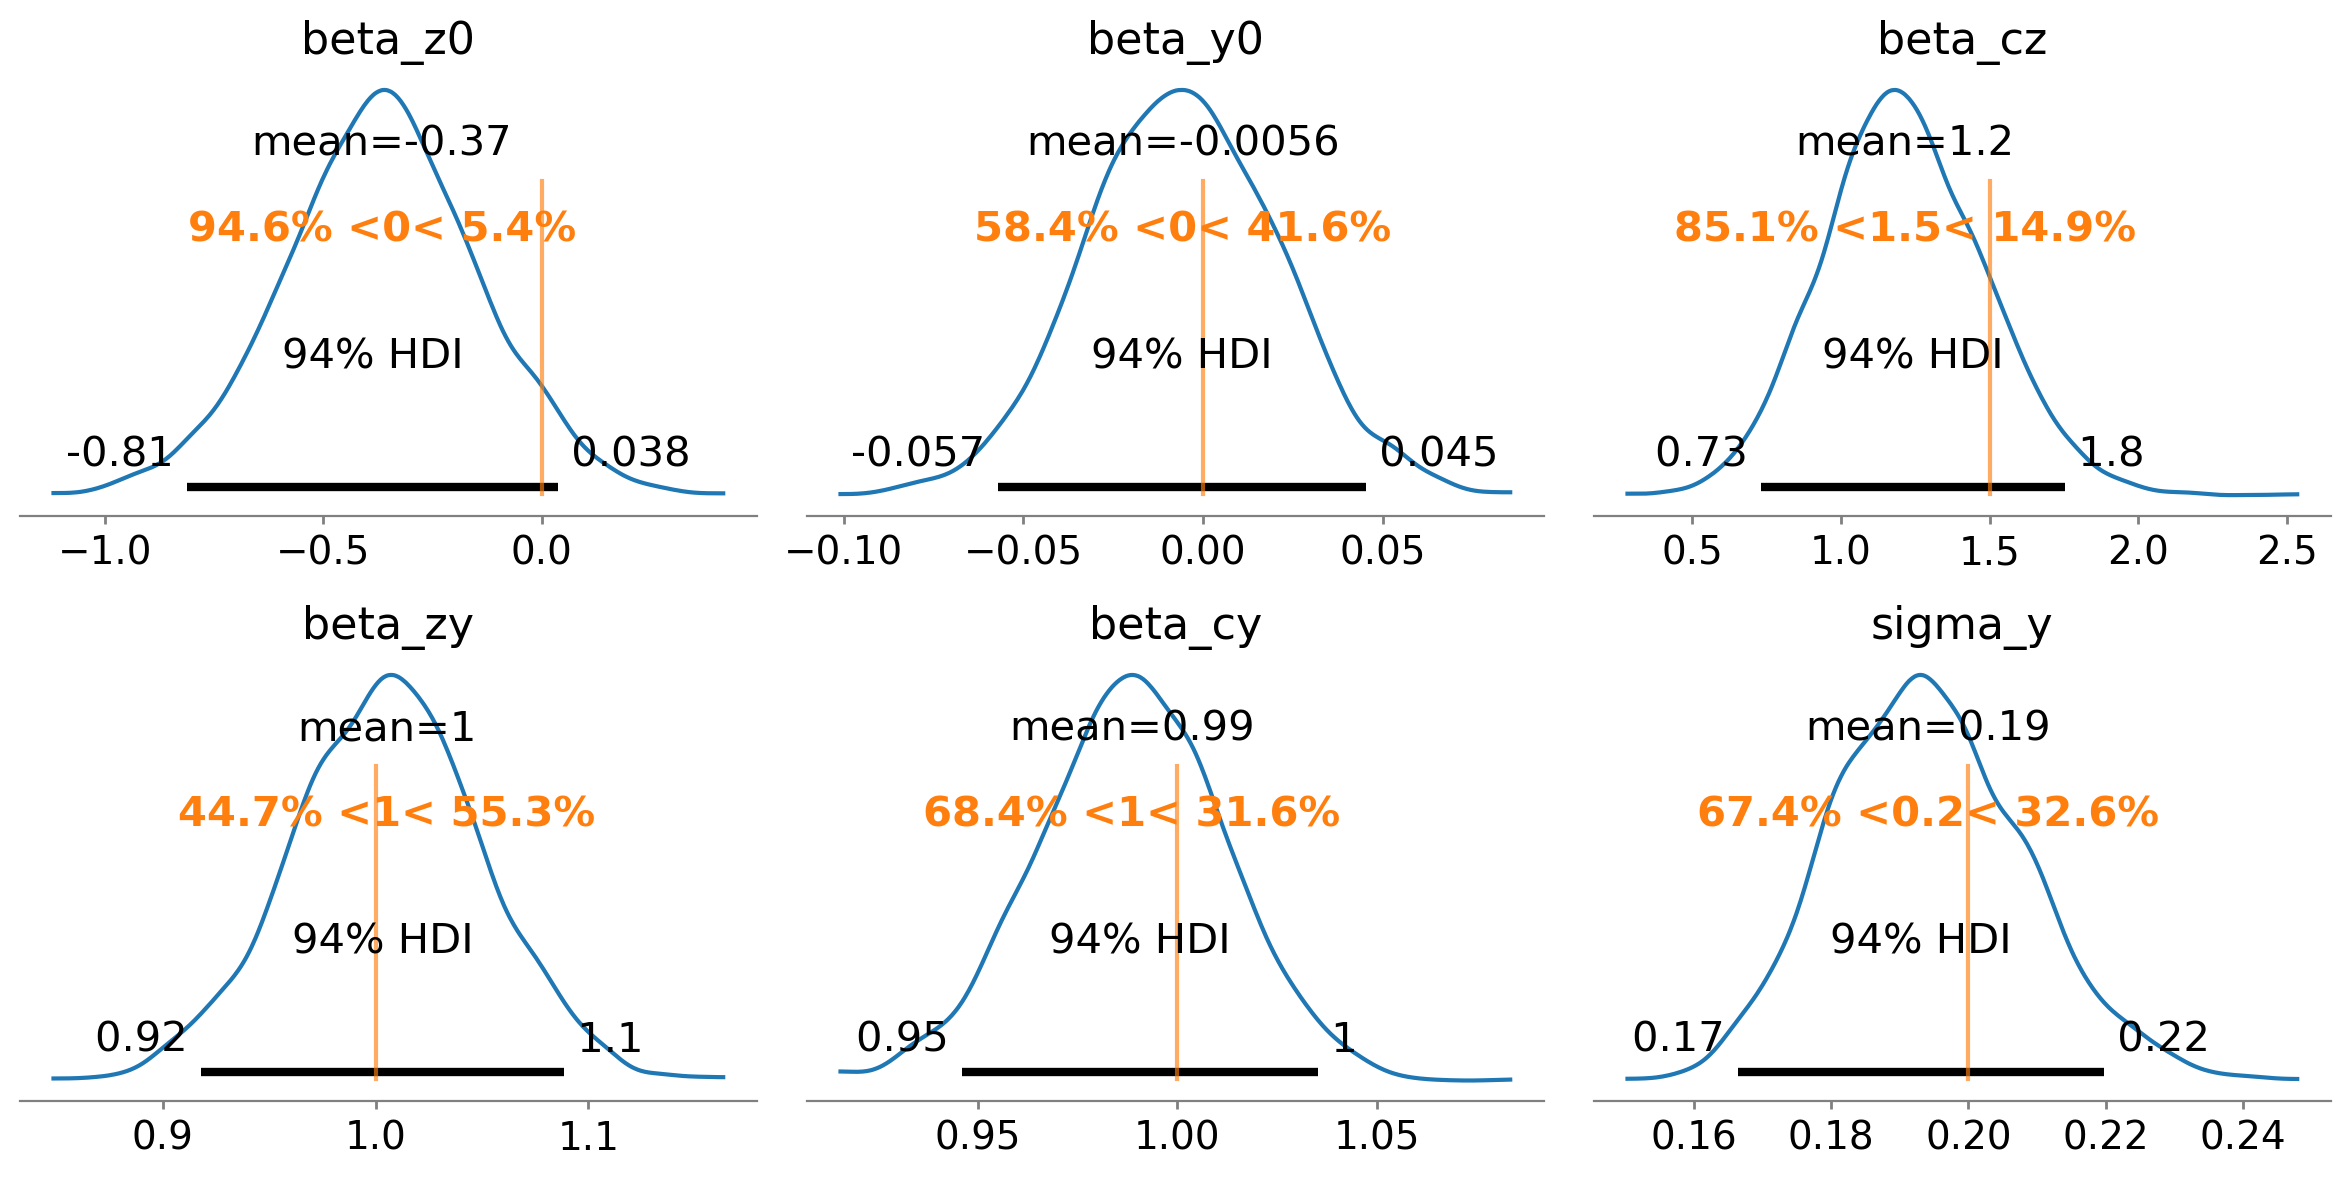

In [20]:
az.plot_posterior(idata, 
                  var_names=list(true_values.keys()), 
                  ref_val=list(true_values.values()), 
                  figsize=(12,6))
plt.tight_layout();

So far we've simply demonstrated that the generative model we wrote can do a good job of recovering the parameters based on data which was generated directly from that data generating process. This can be a very valuable excercise and represents a new Bayesian workflow for those interested in parameter recovery studies. But let's not get distracted by this and return to our causal focus.

### Counterfactuals

For those familiar with causal inference, you'll know that we can calculate the Average Treatment Effect as:

$$
ATE =  P(Y | c, do(z=1)) -  P(Y | c, do(z=0))
$$

Future blog posts will cover how to conduct causal inference using PyMC in more detail, so if you want more information about what is going on here, then keep an eye open for future blog post.

What we want to do is to use the `do` function to calculate counterfactuals as explained above. However, before diving in with something like the following:

```python
model_control = do(model_inference, {"z": np.zeros(N, dtype='int32')})
```

we have to explicitly inject the observed values of $C$ into the model. This step may not be necessary in future versions of PyMC.

In [21]:
# This step is required at the moment, but may not be necessary in future versions of PyMC
model_counterfactual = do(model_inference, {"c": df['c']})

Now we are able to apply the `do` operator to manipulate the graph to set the all the values of $Z$ to either 0 or 1 to calculate $P(Y | c, do(z=0))$ and $P(Y | c, do(z=1))$, respectively.

In [22]:
# P(Y | c, do(z=0))
with do(model_counterfactual, {"z": np.zeros(N, dtype='int32')}, prune_vars=True) as model_control:
    idata_z0 = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_mu"], random_seed=SEED)

# P(Y | c, do(z=1))
with do(model_counterfactual, {"z": np.ones(N, dtype='int32')}, prune_vars=True) as model_treat:
    idata_z1 = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_mu"], random_seed=SEED) 
    
# calculate estimated ITE
ATE_est = idata_z1.predictions - idata_z0.predictions

Sampling: []


Sampling: []


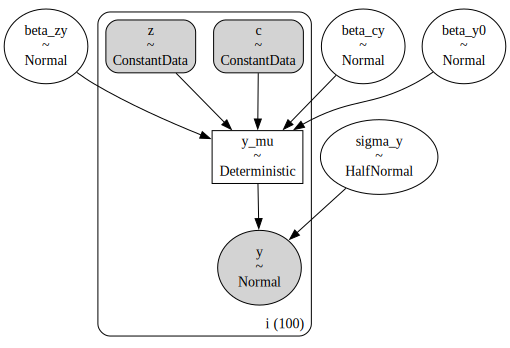

In [23]:
pm.model_to_graphviz(model_control)

In [24]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)
    
    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")
        
    # right plot of estimated ATE
    az.plot_posterior(idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]);

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    plt.tight_layout()
    
def print_percent_error(ATE_est, true_ATE):
    """Utility function to calculate and print the percent error."""
    percent_error = np.abs(ATE_est["y_mu"] - true_ATE) / true_ATE * 100
    hdi = az.hdi(percent_error).sel(i=0)["y_mu"].values
    return f"{percent_error.mean().data:.1f}% ({hdi[0]:.1f} - {hdi[1]:.1f})"

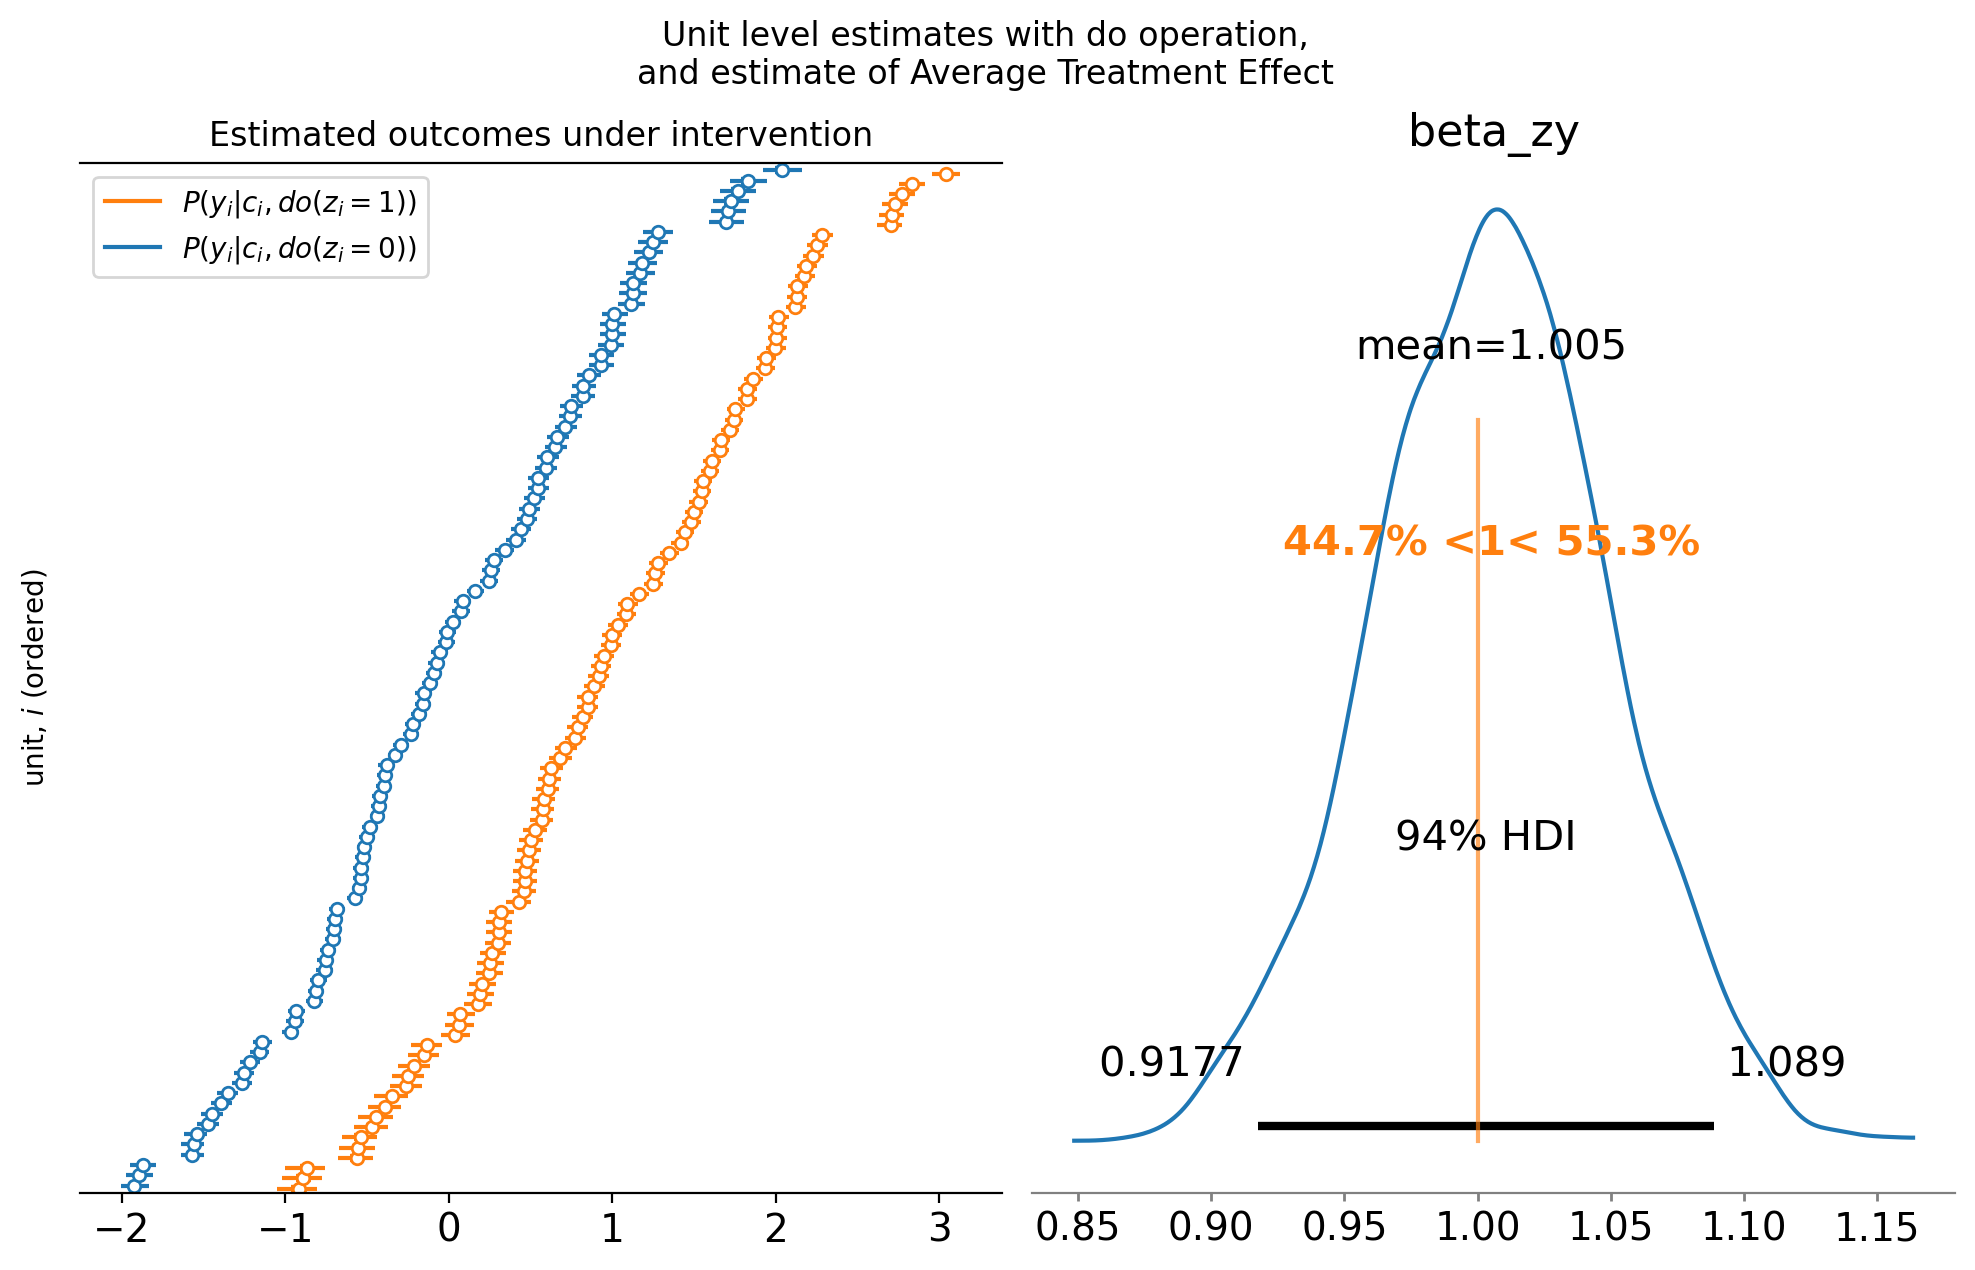

In [25]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)
plt.suptitle("Unit level estimates with do operation,\nand estimate of Average Treatment Effect", y=1.05);

Results of our Bayesian causal inference. The left panel shows our individual level estimates of the outcome $y$ under the counterfactual situations of being in the control ($\operatorname{do}(z=0)$) or treatment ($\operatorname{do}(z=1)$) groups. Each individual has a different outcome due to the influence of the confounding variable, $C$. The right pabel shows our posterior estimate of the Average Treatment Effect of $Z \rightarrow Y$. We can see that we have correctly recovered the true value (of 1) from our simulated data, and that we have quite a tight 95% Bayesian credible interval which indicates relatively high confidence in this estimate.

# Summary

If you've made it this far, hopefully you can see why we are excited about our new tools (`do` and `observe`) to manipulate the symbolic graph representations of probabilistic models in PyMC. At the moment these are still experimental features available in the [`pymc-experimental`](https://github.com/pymc-devs/pymc-experimental) repository. This post shows how users eager to test out this new functionality can do so, but these features will soon migrate into PyMC to become core functionality.

We've seen how graph manipulation with the new `do` and `observe` operators can be used in Bayesian workflows, and we are particularly excited about new _causal_ inference workflows that open up in PyMC. Expect to see more blog posts from us in the future about Bayesian causal inference. In the meantime, you can check out [`CausalPy`](https://causalpy.readthedocs.io/en/latest/), a package we put together for causal inference, built on top of PyMC, currently focussing on inference in quasi-experimental sitations. You can also check out our [announcement video from PyData Global 2022](https://youtu.be/gV6wzTk3o1U).